# Anonymizized Facial Expression: Integrating Superpixel Segmentation for Expression Preserving Dynamic Blurring


A practical implementation is demonstrated through a Python script that processes a static image or real-time video stream, applying the aforementioned techniques to anonymize faces. The script utilizes OpenCV for face detection and skimage for segmentation and blurring, showcasing the feasibility of sophisticated face anonymization in real-time applications.


**1\. Face Detection:**
We can locate and identify facial regions within a frame and use OpenCV’s pre-trained Haar Cascade or deep learning-based face detectors.

**2\. Superpixel Segmentation:**
Then we can break down the identified facial regions into superpixels that conform closely to the visual and geometric boundaries of the face. In the `skimage.segmentation` module we can use the SLIC (Simple Linear Iterative Clustering) function to generate the superpixels.

**3\. Blurring Faces:**
To apply a blurring effect selectively to the superpixelated facial regions we anonymize faces while keeping some key indicators (specifically general facal features and ablitliy to express emotion). For each superpixel within the facial bounding boxes we get the average pixel color, Then we replace the superpixels in the facial regions with their blurred counterparts.


In [2]:
import cv2
import numpy as np
from skimage import exposure, img_as_ubyte
from skimage.segmentation import slic
from skimage import img_as_float
import matplotlib.pyplot as plt


### 1\. Face Detection 

Use OpenCV to detect faces within a given image or video frame 


In [3]:
def detect_faces(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors, minSize=minSize)
    return faces


### 2\. Superpixel Segmentation

Apply the superpixel segmentation to the regions identified as faces, using skimage's SLIC algorithm.




#### [TODO: play around with the sigma param here]

In [4]:
def segment_faces(image, faces, n_segments=25, compactness=15, sigma=1):
    image_float = img_as_float(image)
    masks = []
    for (x, y, w, h) in faces:
        face_region = image_float[y:y+h, x:x+w]
        mask = slic(face_region, n_segments=n_segments, compactness=compactness, sigma=sigma)
        masks.append((x, y, w, h, mask))
    return masks


## Dynamic Blurring

use NumPy to calculate the mean color of the pixels within each segment mask and then assign this average color to all pixels in that segment. This approach effectively anonymizes the facial regions by reducing their detail to uniform color patches, while preserving the overall color distribution of the face.


This function iterates over each segment within the detected face regions, computes the average color of the pixels within each segment, and then sets all pixels in the segment to this average color. This method maintains the structural outline of the faces while simplifying the details, offering a form of anonymization that retains the color palette of the original image.

### Notes:

*   The `average_color` is computed by taking the mean of the pixels within a segment across all color channels (assuming `face_region[segment_mask]` returns an array of pixels for that segment). The `.mean(axis=0)` operation calculates the mean along the vertical axis (the color channels in this case), resulting in the average color of the segment.
*   This approach works with images represented as floating-point arrays with pixel values normalized between 0 and 1. If your images use a different format or range, adjust the normalization accordingly.
*   Remember, this method replaces the detailed texture of the face with flat colors, which might be preferable in scenarios where preserving the general color distribution of the image is more important than maintaining texture or detail within the anonymized regions.

In [6]:
def average_color_faces(image_float, masks):
    for (x, y, w, h, mask) in masks:
        face_region = image_float[y:y+h, x:x+w]
        for segment_val in np.unique(mask):
            segment_mask = mask == segment_val
            # Calculate the average color of the segment
            average_color = face_region[segment_mask].mean(axis=0)
            # Assign the average color to the entire segment
            face_region[segment_mask] = average_color
        image_float[y:y+h, x:x+w] = face_region
    return image_float

## Tuning the effect
*   **Adjusting SLIC Parameters**: The `n_segments` and `compactness` parameters in the SLIC function call play crucial roles in determining the granularity and adherence of superpixels to image boundaries. For a more detailed blur effect:
    
    *   **`n_segments`**: Increase this value to create more, smaller superpixels. This allows for finer granularity in the blur effect, potentially leading to a more detailed outcome.
    *   **`compactness`**: Adjust this value to balance color proximity and space proximity in superpixel formation. A lower value gives more weight to space (shape), while a higher value emphasizes color similarity.


In [7]:
def process_image(image_path, n_segments=25, compactness=15):
    image = cv2.imread(image_path)
    faces = detect_faces(image)
    masks = segment_faces(image, faces, n_segments, compactness)
    image_float = img_as_float(image)
    
    #average superpixel pixel color
    blurred_image_float = average_color_faces(image_float, masks)
    
    # Normalize and convert back to an 8-bit format
    final_image = img_as_ubyte(exposure.rescale_intensity(blurred_image_float, in_range=(0, 1)))
    return final_image


In [8]:
#helper
def display_image(image, title="Image"):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


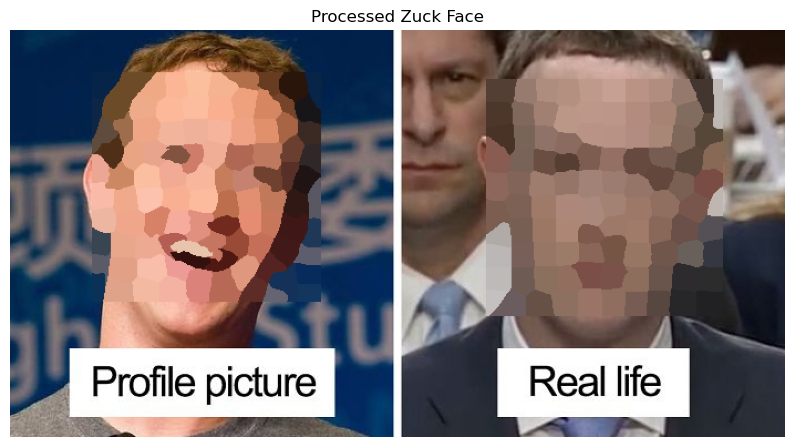

In [22]:
#image_path = 'zuck.jpg'
image_path = 'compare_zuck.jpg'
#image_path = 'happy_zuck.jpg'
#image_path = 'happy_zuck2.png'

processed_image = process_image(image_path, 
                    n_segments=10**2, #I like limiting this, faces can be discribed with 25 shapes puzzle
                    compactness=40, #how loosy goosey the pixels are (low=stranger shapes, higher = more squary)
            ) 

display_image(processed_image, title='Processed Zuck Face')

## Process realtime video streams (bit laggy)

In [10]:
def process_video_stream(n_segments=25, compactness=15):
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        faces = detect_faces(frame)
        masks = segment_faces(frame, faces, n_segments, compactness)
        frame_float = img_as_float(frame)
        processed_frame = average_color_faces(frame_float, masks)
        
        processed_frame = img_as_ubyte(exposure.rescale_intensity(processed_frame, in_range=(0, 1)))
        cv2.imshow('Processed Frame', processed_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

process_video_stream(
    n_segments=10**2, #I like limiting this, faces can be discribed with 25 shapes puzzle
    compactness=25, #how loosy goosey the pixels are (low=stranger shapes, higher = more squary)
)

2024-03-10 19:27:07.741 python[5973:306606] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


### Research Question: Does Superpixel Averaging Preserve Facial Emotion Recognition Better Than Traditional Blurring Techniques in Anonymized Images?

#### Background

In the realm of digital privacy, particularly in the context of video conferencing, social media, and surveillance, anonymizing faces in images and video streams is paramount to protecting individual identities. However, conventional blurring techniques, while effective for anonymization, often strip away crucial emotional cues and expressions, diminishing the ability to convey or interpret feelings and reactions. Superpixel averaging, an alternative approach, promises a novel solution by potentially retaining more structural integrity of facial expressions while ensuring anonymity. This research aims to quantitatively assess the effectiveness of superpixel averaging versus traditional blurring in preserving the recognizability of facial emotions.

#### Objective

To systematically compare the impact of superpixel averaging and traditional blurring on the accuracy of facial emotion recognition. This study will use out-of-the-box facial emotion recognition models to evaluate which anonymization technique better maintains the expressive content of faces.

# TODO should also train the model on detecting the emotion on the blurred images not just useing an out of the box model, will be good to compare



https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer

https://analyticsindiamag.com/top-8-datasets-available-for-emotion-detection/

this one has multiple of the same person:
https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition



# Citations


Preserving Privacy in Image-based Emotion Recognition through User Anonymization
https://dl.acm.org/doi/abs/10.1145/3382507.3418833

GANonymization: A GAN-based Face Anonymization Framework for Preserving Emotional Expressions
https://dl.acm.org/doi/abs/10.1145/3641107